# Getting best results per-shard using CANDLE HPO

In [29]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import os
import sys
from pathlib import Path

import sklearn
import numpy as np
import pandas as pd
from glob import glob

import matplotlib
import matplotlib.pyplot as plt

# Make all python scripts available in the path
sys.path.append('../')

import lrn_crv
import lrn_crv_plot
%matplotlib inline

filepath = Path(os.getcwd())
filepath

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


PosixPath('/vol/ml/apartin/projects/LearningCurves/notebooks')

In [30]:
# HPO runs
hpo_ctrp_nn_dir = Path('/vol/ml/apartin/projects/LearningCurves/hpo_runs/lc_ctrp_nn_reg0_hpo')
hpo_gdsc_nn_dir = Path('/vol/ml/apartin/projects/LearningCurves/hpo_runs/lc_gdsc_nn_reg0_hpo')
hpo_top6_nn_dir = Path('/vol/ml/apartin/projects/LearningCurves/hpo_runs/lc_top6_nn_reg0_hpo')

hpo_ctrp_lgbm_dir = Path('/vol/ml/apartin/projects/LearningCurves/hpo_runs/lc_ctrp_lgbm_hpo')
hpo_gdsc_lgbm_dir = Path('/vol/ml/apartin/projects/LearningCurves/hpo_runs/lc_gdsc_lgbm_hpo')
# hpo_top6_dir = Path('/vol/ml/apartin/projects/LearningCurves/hpo_runs/lc_top6_lgbm_hpo')

# Utils

In [31]:
def top_n_runs(df, tr_size=None, n=10, sort_by_metric='mean_absolute_error', plot=False):
    """ Return top runs based on sort_by_metric. """
    if tr_size is not None:
        df = df[df['tr_size']==tr_size].reset_index(drop=True)
    if sort_by_metric == 'r2':
        df = df.sort_values(sort_by_metric, ascending=False).iloc[:n, :]
    else:
        df = df.sort_values(sort_by_metric, ascending=True).iloc[:n, :]
    
    if plot: display(df.transpose())
    return df.reset_index(drop=True)

# Load results from runs

In [32]:
# base_dir = hpo_ctrp_nn_dir
base_dir = hpo_gdsc_nn_dir
# base_dir = hpo_top6_nn_dir

# base_dir = hpo_ctrp_lgbm_dir
# base_dir = hpo_gdsc_lgbm_dir
# base_dir = hpo_top6_lgbm_dir

# Load
hp = pd.read_csv( base_dir/'hpo_all.csv' )

In [33]:
# Subset of columns
if 'nn' in str(base_dir):
    col_subset = ['tr_size',
                  'batch_size', 'lr', 'opt', 'dr_rate', 'batchnorm', # HPs
                  'epoch_stop', 'epochs',
                  'run_id',
                  # 'clr_mode', 'cv_method', 'scaler',   # potential DL HPs
                  # 'n_trees',  # potential LGBM HPs
                  # 'cell_fea', 'drug_fea', 'target_name',  # features and response
                  # 'framework', 'model_name', 'cv_folds',  # ML settings
                  'shard_step_scale', # Other
                  'mean_absolute_error', 'mean_squared_error', 'median_absolute_error', 'r2', # scores
                 ]
else:
    col_subset = ['tr_size',
                  'gbm_leaves', 'gbm_lr', 'gbm_max_depth', 'gbm_trees', # HPs
                  'run_id',
                  # 'n_trees',  # potential LGBM HPs
                  # 'cell_fea', 'drug_fea', 'target_name',  # features and response
                  # 'framework', 'model_name', 'cv_folds',  # ML settings
                  'shard_step_scale', # Other
                  'mean_absolute_error', 'mean_squared_error', 'median_absolute_error', 'r2', # scores
                 ]

In [34]:
# Cols subset
hp = hp[[c for c in col_subset if c in hp.columns]]
print(hp.shape)

(1683, 13)


In [35]:
hp[:3]

,tr_size,batch_size,lr,opt,dr_rate,batchnorm,epoch_stop,epochs,run_id,shard_step_scale,mean_absolute_error,median_absolute_error,r2
0,16384,32,0.00001,adam,0.0,True,354,600,id_000,log2,0.079476,0.061043,0.566969
1,2048,32,0.00001,adam,0.0,True,424,600,id_000,log2,0.109577,0.079785,-0.013417
2,32768,32,0.00001,adam,0.0,True,188,600,id_000,log2,0.074965,0.056606,0.605526


### Check data

In [36]:
# Certain runs were not completed --> check
hp['tr_size'].value_counts().reset_index().rename(columns={'index': 'subset'}).sort_values('subset').reset_index(drop=True)

,subset,tr_size
0,2048,256
1,4096,256
2,8192,256
3,16384,256
4,32768,251
5,65536,222
6,88416,186


In [39]:
# certain runs were not completed (a more detailed look)
if 'nn' in str(base_dir):
    display(hp.groupby(['tr_size', 'batch_size']).agg({'r2': 'size'}).reset_index().rename(columns={'r2': 'count'})[:10])

,tr_size,batch_size,count
0,2048,32,64
1,2048,64,64
2,2048,128,64
3,2048,256,64
4,4096,32,64
5,4096,64,64
6,4096,128,64
7,4096,256,64
8,8192,32,64
9,8192,64,64


In [40]:
# All HP per subset size
if 'nn' in str(base_dir):
    display(hp.groupby('tr_size').agg({'batch_size': 'unique', 'dr_rate': 'unique', 'opt': 'unique', 'lr': 'unique',
                               'mean_absolute_error': 'min', 'r2': 'max'}).reset_index())
elif 'lgbm' in str(base_dir):
    display(hp.groupby('tr_size').agg({'gbm_leaves': 'unique', 'gbm_lr': 'unique', 'gbm_max_depth': 'unique', 'gbm_trees': 'unique',
                               'mean_absolute_error': 'min', 'r2': 'max'}).reset_index())

,tr_size,batch_size,dr_rate,opt,lr,mean_absolute_error,r2
0,2048,"[32, 64, 128, 256]","[0.0, 0.1, 0.2, 0.3]","[adam, sgd]","[1e-05, 0.0001, 0.001, 0.01]",0.083689,0.523973
1,4096,"[32, 64, 128, 256]","[0.0, 0.1, 0.2, 0.3]","[adam, sgd]","[1e-05, 0.0001, 0.001, 0.01]",0.078094,0.567769
2,8192,"[32, 64, 128, 256]","[0.0, 0.1, 0.2, 0.3]","[adam, sgd]","[1e-05, 0.0001, 0.001, 0.01]",0.075140,0.607003
3,16384,"[32, 64, 128, 256]","[0.0, 0.1, 0.2, 0.3]","[adam, sgd]","[1e-05, 0.0001, 0.001, 0.01]",0.071646,0.640094
4,32768,"[32, 64, 128, 256]","[0.0, 0.1, 0.2, 0.3]","[adam, sgd]","[1e-05, 0.0001, 0.001, 0.01]",0.068200,0.671603
5,65536,"[32, 64, 128, 256]","[0.0, 0.1, 0.2, 0.3]","[adam, sgd]","[1e-05, 0.0001, 0.001, 0.01]",0.063936,0.706599
6,88416,"[64, 128, 256, 32]","[0.0, 0.1, 0.2, 0.3]","[adam, sgd]","[1e-05, 0.0001, 0.001, 0.01]",0.061893,0.721139


In [41]:
# Certain runs were did not converge (early stop was not activated)
if 'nn' in str(base_dir):
    not_cnv = hp[ hp['epoch_stop']==hp['epochs'] ]
    print('Early stop was not activated for {} runs out of {}'.format( not_cnv.shape[0], hp.shape[0] ))

Early stop was not activated for 390 runs out of 1683


## Plot all runs per metric

In [42]:
met = 'mean_absolute_error'

# Plot settings
figsize=(7,5)
# xtick_scale, ytick_scale = 'linear', 'linear'
xtick_scale, ytick_scale = 'log2', 'log2'

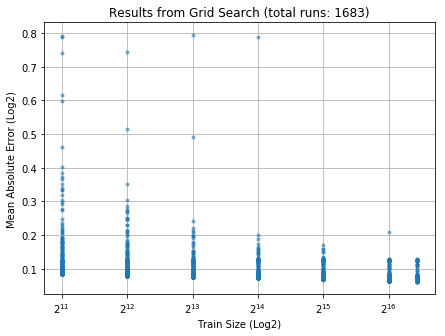

In [43]:
fig, ax = plt.subplots(figsize=figsize)
plt.plot(hp['tr_size'], hp[met], '.', alpha=0.5); plt.grid(True); plt.xlabel('Train Size (Log2)'); plt.ylabel(lrn_crv_plot.capitalize_metric(met) + ' (Log2)');
ax.set_title('Results from Grid Search (total runs: {})'.format(hp.shape[0]))
ax.set_xscale('log', basex=2)
# ax.set_yscale('log', basey=2)

# Compare PS-HPO and LS-HPO

In [44]:
plot_kwargs = {'plot_fit': True, 'metric_name': met, 'xtick_scale': xtick_scale, 'ytick_scale': xtick_scale,
               'figsize': figsize}

## Per-Subset HPO
Extract the best performance score for every shard (for each metric)

In [45]:
ps_best = hp.sort_values(met, ascending=True).drop_duplicates(['tr_size']).sort_values('tr_size').reset_index(drop=True)
ps_best

,tr_size,batch_size,lr,opt,dr_rate,batchnorm,epoch_stop,epochs,run_id,shard_step_scale,mean_absolute_error,median_absolute_error,r2
0,2048,64,0.0100,adam,0.2,True,151,600,id_105,log2,0.083689,0.062011,0.514818
1,4096,32,0.0001,adam,0.2,True,318,600,id_040,log2,0.078094,0.057655,0.565306
2,8192,32,0.0001,adam,0.2,False,179,600,id_056,log2,0.075140,0.055555,0.600735
3,16384,64,0.0010,adam,0.3,False,107,600,id_093,log2,0.071646,0.053056,0.633708
4,32768,64,0.0100,sgd,0.2,True,299,600,id_233,log2,0.068200,0.051545,0.671603
5,65536,128,0.0001,adam,0.3,False,234,600,id_062,log2,0.063936,0.046559,0.702178
6,88416,64,0.0001,adam,0.2,False,210,600,id_057,log2,0.061893,0.043283,0.712297


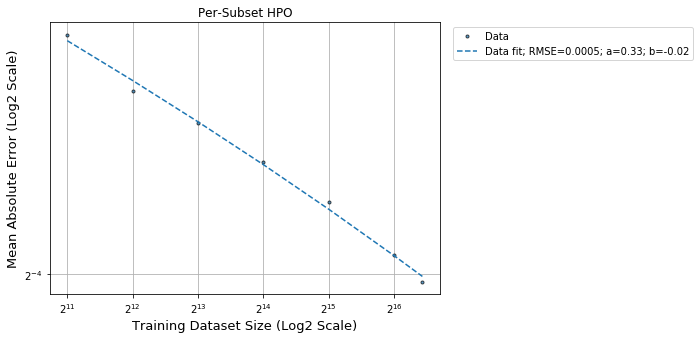

In [46]:
lrn_crv_plot.plot_lrn_crv_power_law( x = ps_best['tr_size'], y = ps_best[met], title='Per-Subset HPO', **plot_kwargs );

# Largest-Subset HPO
Extract the best performance score for the largest shard (for each metric)

In [47]:
best = top_n_runs(hp, tr_size=hp['tr_size'].max(), n=1, sort_by_metric=met, plot=False)
display(best)

,tr_size,batch_size,lr,opt,dr_rate,batchnorm,epoch_stop,epochs,run_id,shard_step_scale,mean_absolute_error,median_absolute_error,r2
0,88416,64,0.0001,adam,0.2,False,210,600,id_057,log2,0.061893,0.043283,0.712297


In [48]:
# idx = (hp['opt']==best['opt'][0]) & (hp['lr']==best['lr'][0]) & (hp['dr_rate']==best['dr_rate'][0]) & (hp['batch_size']==best['batch_size'][0]) & (hp['batchnorm']==best['batchnorm'][0])
# ls_best = hp[ idx ].sort_values('tr_size').reset_index(drop=True)

In [49]:
if 'nn' in str(base_dir):
    prm_names = ['dr_rate', 'opt', 'lr', 'batchnorm', 'batch_size']
elif 'lgbm' in str(base_dir):
    prm_names = ['gbm_trees', 'gbm_max_depth', 'gbm_lr', 'gbm_leaves']

In [50]:
idx = pd.Series(True, index=range(hp.shape[0]))
for c in prm_names:
    # print(c, best[c][0])
    idx = idx & ( hp[c] == best[c][0] )
    
ls_best = hp[ idx ].sort_values('tr_size').reset_index(drop=True)

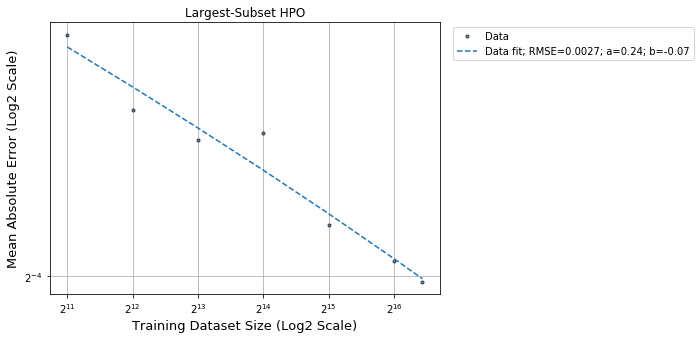

In [51]:
lrn_crv_plot.plot_lrn_crv_power_law( x = ls_best['tr_size'], y = ls_best[met], title='Largest-Subset HPO', **plot_kwargs );

## PS-HPO vs LS-HPO fit

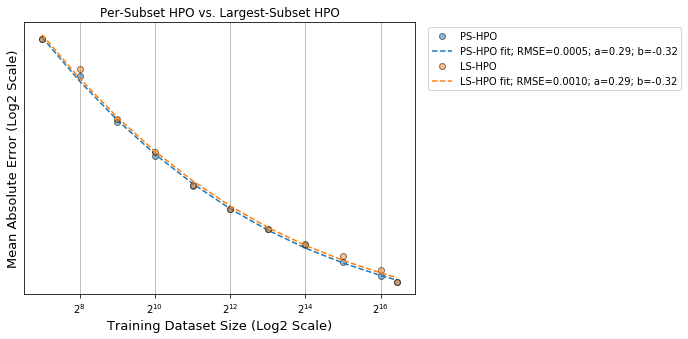

In [25]:
marker='o'; alpha=0.5

ax, pwr_law_params = lrn_crv_plot.plot_lrn_crv_power_law(x=ps_best['tr_size'], y=ps_best[met],
                                                         marker=marker, alpha=alpha, label='PS-HPO',
                                                         ax=None, **plot_kwargs)

ax, pwr_law_params = lrn_crv_plot.plot_lrn_crv_power_law(x=ls_best['tr_size'], y=ls_best[met],
                                                         marker=marker, alpha=alpha, label='LS-HPO', 
                                                         ax=ax, **plot_kwargs,
                                                         title='Per-Subset HPO vs. Largest-Subset HPO')

## PS-HPO vs LS-HPO extrapolate

In [28]:
m0 = 9

(<matplotlib.axes._subplots.AxesSubplot at 0x7f3e30814390>,
 {'alpha': 0.29325062145429553,
  'beta': -0.3238105835844031,
  'gamma': 0.059407797845529096})

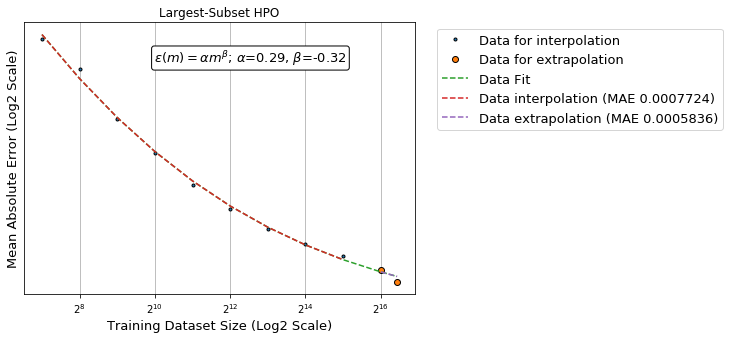

In [29]:
lrn_crv_plot.lrn_crv_power_law_extrapolate(x=ls_best['tr_size'], y=ls_best[met],
                                           m0=m0, **plot_kwargs, title='Largest-Subset HPO')

(<matplotlib.axes._subplots.AxesSubplot at 0x7f3e3085d6d8>,
 {'alpha': 0.2967430511815115,
  'beta': -0.32917909441285775,
  'gamma': 0.05953145919464494})

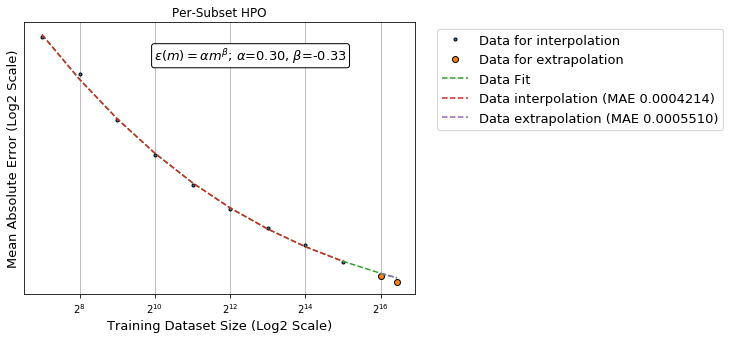

In [30]:
lrn_crv_plot.lrn_crv_power_law_extrapolate(x=ps_best['tr_size'], y=ps_best[met],
                                           m0=m0, **plot_kwargs, title='Per-Subset HPO')

# Curve Fit
Matlab Package
- https://www.mathworks.com/help/stats/examples/weighted-nonlinear-regression.html<br>

R Package
- https://stat.ethz.ch/R-manual/R-devel/library/stats/html/nls.html
- https://stackoverflow.com/questions/27722664/r-fitting-power-law-curve-to-data-starting-value-for-c
- https://www.rdocumentation.org/packages/stats/versions/3.6.1/topics/nls

In [61]:
x = ps_best['tr_size']
y = ps_best['mean_absolute_error']

In [80]:
# np.polyfit returns polynomial coefficients, highest power first
# y = Ax^b
# log(y) = log(Ax^b) = log(A) + b*log(x) --> log(A) = p[1], b = p[0]
expon, amp = np.polyfit( np.log(x+1.e-14), np.log(y+1.e-14), deg=1 )

In [69]:
w = x / (np.exp(1) * (1-np.exp(1)))
w = 2**(np.arange(len(x)) + 1)

In [70]:
w

array([  2,   4,   8,  16,  32,  64, 128, 256])

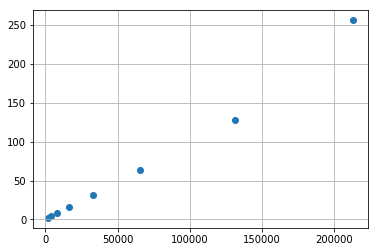

In [72]:
plt.scatter(x, w); plt.grid(True)

In [73]:
expon, amp = np.polyfit(np.log(x+1.e-14), np.log(y+1.e-14), 1, w=w)

In [74]:
amp

-2.05392912636267

In [75]:
expon

-0.08736553525661991